In [5]:
from dgd.utils.utils5 import exhaustive_cut_enumeration_dag, generate_subgraph, substitute_subgraph, is_fanout_free_standalone, calculate_truth_table
import random
import matplotlib.pyplot as plt
import networkx as nx

Simple test substituting a subgraph

In [ ]:


def generate_random_dag(
    num_nodes: int = 4,
    num_sources: int = 4,
    num_sinks: int = 1,
    max_incoming: int = 2,
    seed: int = None
) -> nx.DiGraph:
    """
    Generate a random DAG on `num_nodes` nodes with exactly `num_sources` sources,
    exactly `num_sinks` sinks, and at most `max_incoming` incoming edges per node.
    Every non-source has ≥1 incoming; every non-sink has ≥1 outgoing.
    """
    if seed is not None:
        random.seed(seed)

    if num_sources + num_sinks > num_nodes:
        raise ValueError("num_sources + num_sinks must be <= num_nodes")

    nodes = list(range(num_nodes))
    sources = set(random.sample(nodes, num_sources))
    others = [n for n in nodes if n not in sources]
    sinks = set(random.sample(others, num_sinks))
    intermediates = [n for n in others if n not in sinks]

    # build a topological ordering: sources → intermediates → sinks
    ordering = list(sources) + intermediates + list(sinks)

    G = nx.DiGraph()
    G.add_nodes_from(nodes)

    # 1) Give each non-source exactly 1..max_incoming parents from earlier in the ordering
    for idx, node in enumerate(ordering):
        if node in sources:
            continue
        possible_parents = ordering[:idx]
        k = random.randint(1, min(max_incoming, len(possible_parents)))
        for p in random.sample(possible_parents, k):
            G.add_edge(p, node)

    # 2) Post-process: ensure *only* our designated sinks have out-degree 0
    designated_sink = next(iter(sinks))
    extra_sinks = [n for n in G.nodes()
                   if G.out_degree(n) == 0 and n != designated_sink]

    for n in extra_sinks:
        idx_n = ordering.index(n)
        # look for a “later” node with room for another incoming edge
        candidates = [m for m in ordering[idx_n+1:]
                      if G.in_degree(m) < max_incoming]
        # fallback to *any* node if no later ones have space
        if not candidates:
            candidates = [m for m in G.nodes()
                          if m != n and G.in_degree(m) < max_incoming]
        if candidates:
            m = random.choice(candidates)
            G.add_edge(n, m)
        # if *still* no candidates, we give up — extremely unlikely in practice

    return G


# quick smoke-test
if __name__ == "__main__":
    G = generate_random_dag(num_nodes=12, seed=42)
    num_src = sum(1 for _, d in G.in_degree() if d == 0)
    num_snk = sum(1 for _, d in G.out_degree() if d == 0)
    print(f"sources: {num_src}, sinks: {num_snk}")
    assert num_src == 4
    assert num_snk == 1


In [ ]:
# compute a layout
pos = nx.spring_layout(G)

# draw nodes & edges
nx.draw(G, pos,
        with_labels=True,     # draw node IDs as labels
        node_size=500,        # tweak to your liking
        font_size=12)

plt.show()

In [ ]:
target_node=11
potential_cuts = exhaustive_cut_enumeration_dag(G, 4, target_node, filter_redundant=True)
potential_cuts

In [ ]:
fanout_free_cuts = []
for potential_cut in potential_cuts: 
    if is_fanout_free_standalone(G, target_node, potential_cut):
        fanout_free_cuts.append(potential_cut)
        

In [ ]:
fanout_free_cuts

In [ ]:
cuts = []
for fanout_free_cut in fanout_free_cuts:
    potential_subgraph  = generate_subgraph(G, target_node, fanout_free_cut, draw=False)
    if len([n for n in potential_subgraph  if potential_subgraph.in_degree(n) == 0]) == len(fanout_free_cut):
        cuts.append(fanout_free_cut)
cuts

In [ ]:
cut = (0, 1, 8, 10)
#cut = (0, 2, 4, 10)
subgraph  = generate_subgraph(G, target_node, cut, draw=True)
print(len([n for n in subgraph if subgraph.in_degree(n) == 0]) == len(cut))

In [ ]:
calculate_truth_table(subgraph)

In [ ]:
# Draw it with integer labels
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos,
        with_labels=True,   # show node IDs
        node_size=200,
        font_size=14)
plt.show()

In [ ]:
# Create a directed graph called replacement_graph
replacement_graph = nx.DiGraph()

# Add nodes: 0 and 1 will be your sources, 
# 2 will be the intermediate, and 3 the sink
replacement_graph.add_nodes_from([0, 1, 2, 3])

# Connect each source → intermediate, then intermediate → sink
replacement_graph.add_edge(0, 2)
replacement_graph.add_edge(1, 2)
replacement_graph.add_edge(2, 3)

# (Optional) sanity check
assert sum(1 for _, d in replacement_graph.in_degree()  if d == 0) == 2   # two sources
assert sum(1 for _, d in replacement_graph.out_degree() if d == 0) == 1   # one sink

# Draw it with integer labels
pos = nx.spring_layout(replacement_graph)
nx.draw(replacement_graph, pos,
        with_labels=True,   # show node IDs
        node_size=600,
        font_size=14)
plt.show()

In [ ]:
new_solution = substitute_subgraph(G, subgraph, replacement_graph, draw_relabeling = True)

In [ ]:
pos = nx.spring_layout(new_solution)

# draw nodes & edges
nx.draw(new_solution, pos,
        with_labels=True,     # draw node IDs as labels
        node_size=500,        # tweak to your liking
        font_size=12)

plt.show()

Test using real NIGs

In [ ]:
import pickle
import random
import matplotlib.pyplot as plt
import networkx as nx
from dgd.utils.utils5 import exhaustive_cut_enumeration_dag, generate_subgraph, substitute_subgraph, is_fanout_free_standalone, calculate_truth_table

In [ ]:
path = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/dgd/data/NIGs_4_inputs/0x0FD5_NIG_unoptimized.pkl"

In [ ]:
def load_graph_pickle(filename):
    num_nodes, edges, node_attrs = pickle.load(open(filename, "rb"))
    G = nx.DiGraph()
    for n, attr in node_attrs.items():
        G.add_node(n, type=attr) if attr is not None else G.add_node(n)
    G.add_edges_from(edges)
    return G

G = load_graph_pickle(path)

In [ ]:
# compute a layout
pos = nx.spring_layout(G)

# draw nodes & edges
nx.draw(G, pos,
        with_labels=True,     # draw node IDs as labels
        node_size=500,        # tweak to your liking
        font_size=12)

plt.show()

In [ ]:
target_node=66
potential_cuts = exhaustive_cut_enumeration_dag(G, 4, target_node, filter_redundant=True)
potential_cuts

In [ ]:
fanout_free_cuts = []
for potential_cut in potential_cuts: 
    if is_fanout_free_standalone(G, target_node, potential_cut):
        fanout_free_cuts.append(potential_cut)
        

In [ ]:
fanout_free_cuts

In [ ]:
cuts = []
for fanout_free_cut in fanout_free_cuts:
    potential_subgraph  = generate_subgraph(G, target_node, fanout_free_cut, draw=False)
    if len([n for n in potential_subgraph  if potential_subgraph.in_degree(n) == 0]) == len(fanout_free_cut):
        cuts.append(fanout_free_cut)
cuts

In [ ]:
cut = (0, 1, 2, 3)
#cut = (0, 2, 4, 10)
subgraph  = generate_subgraph(G, target_node, cut, draw=True)
print(len([n for n in subgraph if subgraph.in_degree(n) == 0]) == len(cut))

In [ ]:
calculate_truth_table(subgraph)

In [ ]:
# Draw it with integer labels
pos = nx.spring_layout(subgraph)
nx.draw(subgraph, pos,
        with_labels=True,   # show node IDs
        node_size=200,
        font_size=14)
plt.show()

Complete branch substitution analysis

In [57]:
import pickle

file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/notebooks/0x17_ML_topology_designs_reduced.pkl"

with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)   
 
print(f"Number of biological circuits: {len(reduced_graphs)}")

Number of biological circuits: 7


In [58]:
G = reduced_graphs[4] 

Node attributes:
0: {'type': 'input'}
1: {'type': 'input'}
2: {'type': 'input'}
13: {'type': 'output'}
20: {}
23: {}
24: {}
25: {}
26: {}
27: {}


/tmp/ipykernel_1465393/500612313.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


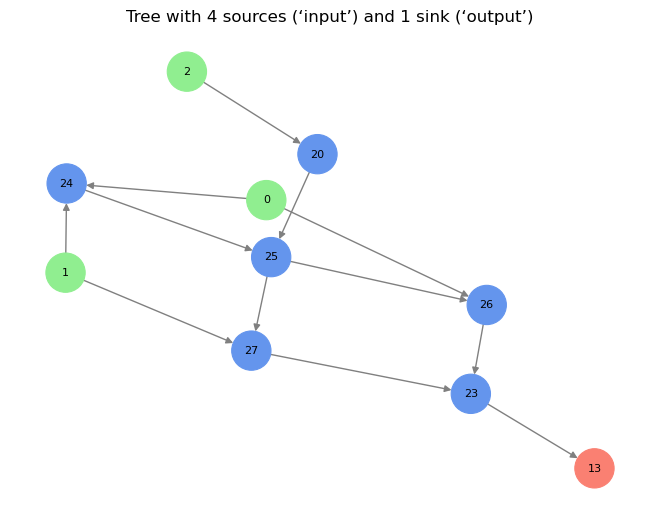

In [60]:


import networkx as nx
import matplotlib.pyplot as plt
'''
# ------------------------------------------------------------------
# 1) Build a directed “tree-like” graph with 10 nodes
# ------------------------------------------------------------------
G = nx.DiGraph()

# ── node sets ─────────────────────────────────────────────────────
sources       = [0, 1, 2, 3]     # 4 source nodes
sink          = 9                # single sink
intermediates = [4, 5, 6, 7, 8]  # the remaining 5 nodes

# add nodes with attributes
G.add_nodes_from(sources, type="input")
G.add_node(sink,  type="output")
G.add_nodes_from(intermediates)          # no special attributes

# ── edges (every node gets a unique parent → classic tree shape) ──
G.add_edges_from([(0, 4), (4, 5), (5, sink)])        # path 0 → 9
G.add_edges_from([(1, 6), (6, 7), (7, sink)])        # path 1 → 9
G.add_edges_from([(2, 8), (8, sink)])                # path 2 → 9
G.add_edge(3, sink)                                  # path 3 → 9
'''
# ------------------------------------------------------------------
# 2) Quick check of node attributes
# ------------------------------------------------------------------
print("Node attributes:")
for n, attrs in G.nodes(data=True):
    print(f"{n}: {attrs}")

# ------------------------------------------------------------------
# 3) Draw the graph (top-down tree layout via Graphviz’s ‘dot’)
# ------------------------------------------------------------------
try:
    pos = nx.nx_agraph.graphviz_layout(G, prog="dot")   # needs pygraphviz
except ImportError:
    # fall back to a generic spring layout if Graphviz isn’t available
    pos = nx.spring_layout(G)

node_colors = [
    "lightgreen"  if G.nodes[n].get("type") == "input"  else
    "salmon"      if G.nodes[n].get("type") == "output" else
    "cornflowerblue"
    for n in G.nodes
]

nx.draw(
    G, pos,
    with_labels=True,
    arrows=True,
    node_size=800,
    node_color=node_colors,
    edge_color="gray",
    linewidths=0.8,
    font_size=8,
)
plt.title("Tree with 4 sources (‘input’) and 1 sink (‘output’)")
plt.tight_layout()
plt.show()


In [61]:
print(list(G.nodes(data=True)))

[(0, {'type': 'input'}), (1, {'type': 'input'}), (2, {'type': 'input'}), (13, {'type': 'output'}), (20, {}), (23, {}), (24, {}), (25, {}), (26, {}), (27, {})]


In [64]:
target_node=25

potential_cuts = exhaustive_cut_enumeration_dag(G, 4, target_node, filter_redundant=True)

fanout_free_cuts = []
for potential_cut in potential_cuts: 
    if is_fanout_free_standalone(G, target_node, potential_cut):
        fanout_free_cuts.append(potential_cut)
        
fanout_free_cuts

[(0, 1, 2), (0, 1, 20), (2, 24), (20, 24)]

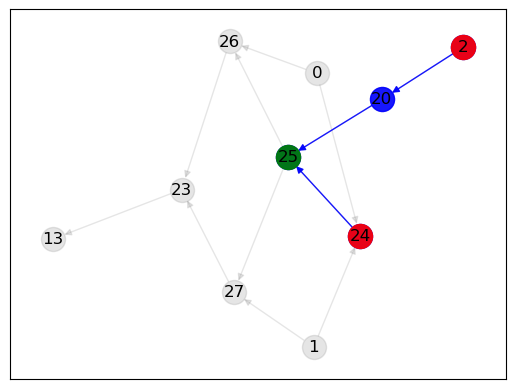

In [69]:
subgraph  = generate_subgraph(G, target_node = target_node, cut = (24, 2), draw=True)

Node attributes:
0: {'type': 'input'}
1: {'type': 'input'}
2: {}
3: {}
4: {}
5: {}
6: {}


/tmp/ipykernel_1465393/2224763767.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


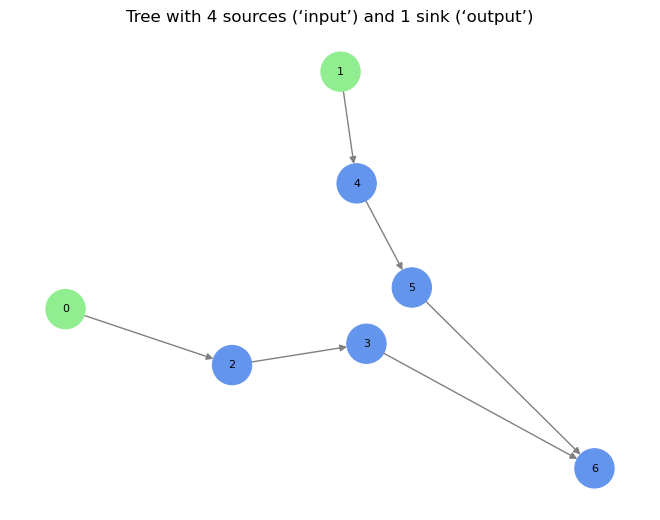

In [86]:
replacement_graph = nx.DiGraph()

# ── node sets ──────────────────────────────────────────────────
sources       = [0, 1]           # 2 source nodes
sink          = 6                # single sink
intermediates = [2, 3, 4, 5]     # remaining nodes

# add nodes with attributes
replacement_graph.add_nodes_from(sources, type="input")
#replacement_graph.add_node(sink, type="output")
replacement_graph.add_nodes_from(intermediates)         # no attributes

# ── edges (each source has its own unique path to the sink) ────
replacement_graph.add_edges_from([(0, 2), (2, 3), (3, sink)])  # path 0 → 6
replacement_graph.add_edges_from([(1, 4), (4, 5), (5, sink)])  # path 1 → 6

# ---------------------------------------------------------------
# Quick check of node attributes
# ---------------------------------------------------------------
print("Node attributes:")
for n, attrs in replacement_graph.nodes(data=True):
    print(f"{n}: {attrs}")
    
try:
    pos = nx.nx_agraph.graphviz_layout(replacement_graph, prog="dot")   # needs pygraphviz
except ImportError:
    # fall back to a generic spring layout if Graphviz isn’t available
    pos = nx.spring_layout(replacement_graph, seed=42)

node_colors = [
    "lightgreen"  if replacement_graph.nodes[n].get("type") == "input"  else
    "salmon"      if replacement_graph.nodes[n].get("type") == "output" else
    "cornflowerblue"
    for n in replacement_graph.nodes
]

nx.draw(
    replacement_graph, pos,
    with_labels=True,
    arrows=True,
    node_size=800,
    node_color=node_colors,
    edge_color="gray",
    linewidths=0.8,
    font_size=8,
)
plt.title("Tree with 4 sources (‘input’) and 1 sink (‘output’)")
plt.tight_layout()
plt.show()

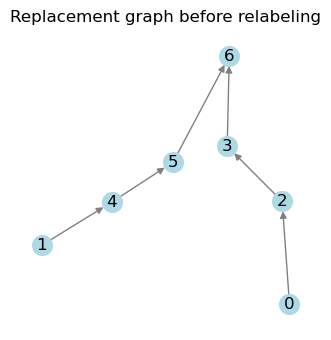

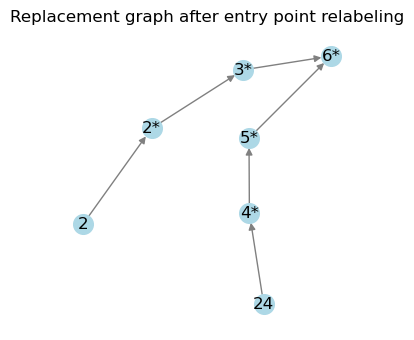

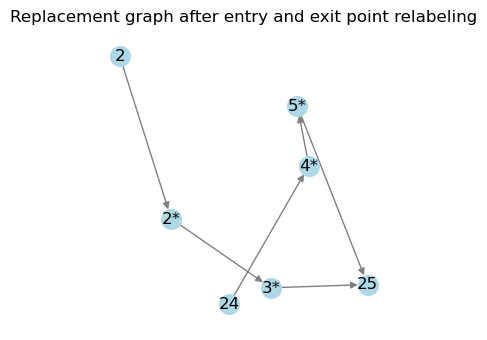

In [87]:
new_solution = substitute_subgraph(G, subgraph, replacement_graph, draw_relabeling = True)

/tmp/ipykernel_1465393/908501604.py:25: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


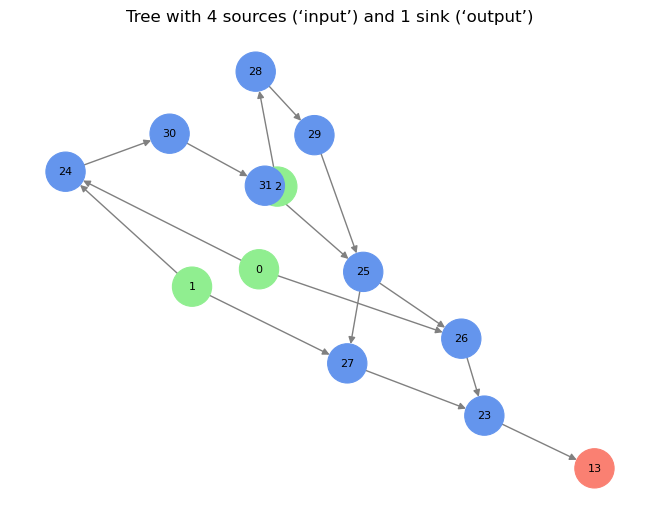

In [98]:
try:
    pos = nx.nx_agraph.graphviz_layout(new_solution, prog="dot")   # needs pygraphviz
except ImportError:
    # fall back to a generic spring layout if Graphviz isn’t available
    pos = nx.spring_layout(new_solution)

node_colors = [
    "lightgreen"  if new_solution.nodes[n].get("type") == "input"  else
    "salmon"      if new_solution.nodes[n].get("type") == "output" else
    "cornflowerblue"
    for n in new_solution.nodes
]

nx.draw(
    new_solution, pos,
    with_labels=True,
    arrows=True,
    node_size=800,
    node_color=node_colors,
    edge_color="gray",
    linewidths=0.8,
    font_size=8,
)
plt.title("Tree with 4 sources (‘input’) and 1 sink (‘output’)")
plt.tight_layout()
plt.show()

In [ ]:
generate_subgraph(new_solution, target_node = target_node, cut = (24, 2), draw=True)

Permutation testing

In [113]:
from dgd.utils.utils5 import calculate_truth_table_v2

In [114]:
def hex_from_signature(sig):
    """
    Convert a truth-table signature tuple, e.g. (0,1,1,0,0,1,1,0),
    into its hexadecimal representation.

    • The first element of `sig` is treated as the most-significant bit,
      matching the convention in your NIG file names.
    • Pads with leading zeroes so that 4 signature bits → 1 hex digit.
    """
    val = 0
    for bit in sig:
        val = (val << 1) | bit
    width = max(1, len(sig) // 4)              # 8 bits → 2 hex digits, etc.
    return f"0x{val:0{width}X}"                # uppercase hex

In [118]:
def truth_table_signature(tt):
    """
    Convert the dict {inputs → outputs} returned by calculate_truth_table_v2
    into a single immutable tuple that can be used as a dict key.
    For multi-output circuits we simply concatenate the bits.
    """
    flat = []
    for inp in sorted(tt):                 # lexicographic input order
        # 'outputs' is a tuple even for single-output circuits
        flat.extend(tt[inp])
    return tuple(flat)                     # e.g. (0,1,1,0,1,0,0,1)

In [115]:
import pickle

file_name = "/home/gridsan/spalacios/Designing complex biological circuits with deep neural networks/scripts/runs/20250706_single_circuit_0x22C6/seed_1/optimal_topologies/optimal_topologies.pkl"

with open(file_name, "rb") as f:
    reduced_graphs = pickle.load(f)   
 
print(f"Number of biological circuits: {len(reduced_graphs)}")

Number of biological circuits: 4


In [120]:
G = reduced_graphs[0]
hex_from_signature(truth_table_signature(calculate_truth_table_v2(G)))

'0x22C6'

In [122]:
import itertools
import networkx as nx   # just for clarity

# -------------------------------------------------------------
# 1) Collect source nodes
#    • Prefer nodes tagged with type='input'
#    • Otherwise fall back to “no incoming edges”
# -------------------------------------------------------------
source_nodes = [
    n for n, data in G.nodes(data=True)
    if data.get("type") == "input" or G.in_degree(n) == 0
]

if len(source_nodes) < 2:
    raise ValueError("Need at least two sources to permute!")

print(f"Sources: {source_nodes}\n")

# -------------------------------------------------------------
# 2) Loop over every permutation, relabel just the sources,
#    compute the signature → hex, and print it.
# -------------------------------------------------------------
for perm in itertools.permutations(source_nodes):
    mapping = dict(zip(source_nodes, perm))

    # Relabel sources only (copy=True leaves original G unchanged)
    G_perm = nx.relabel_nodes(G, mapping, copy=True)

    # Your existing signature → hex pipeline
    hex_str = hex_from_signature(
        truth_table_signature(calculate_truth_table_v2(G_perm))
    )

    # Show which permutation produced which hex
    print(f"{perm}  →  {hex_str}")


Sources: [0, 1, 2, 3]

(0, 1, 2, 3)  →  0x22C6
(0, 1, 3, 2)  →  0x44A6
(0, 2, 1, 3)  →  0x0AD2
(0, 2, 3, 1)  →  0x509A
(0, 3, 1, 2)  →  0x0CB4
(0, 3, 2, 1)  →  0x309C
(1, 0, 2, 3)  →  0x2C26
(1, 0, 3, 2)  →  0x4A46
(1, 2, 0, 3)  →  0x0DA2
(1, 2, 3, 0)  →  0x590A
(1, 3, 0, 2)  →  0x0BC4
(1, 3, 2, 0)  →  0x390C
(2, 0, 1, 3)  →  0x381A
(2, 0, 3, 1)  →  0x6252
(2, 1, 0, 3)  →  0x318A
(2, 1, 3, 0)  →  0x6522
(2, 3, 0, 1)  →  0x23D0
(2, 3, 1, 0)  →  0x2D30
(3, 0, 1, 2)  →  0x581C
(3, 0, 2, 1)  →  0x6434
(3, 1, 0, 2)  →  0x518C
(3, 1, 2, 0)  →  0x6344
(3, 2, 0, 1)  →  0x45B0
(3, 2, 1, 0)  →  0x4B50
